In [36]:
import jax
import jax.numpy as jnp
import chex

from jax import lax
from gymnax.environments import environment, spaces
from typing import Tuple, Optional, NamedTuple, Callable
from flax import struct
from src.utils import PRNGSequence, moving_average

from jax import config as cnfg

cnfg.update("jax_debug_nans", True)
cnfg.update("jax_disable_jit", False)

def moving_average(data, window_size):
    """Smooth data by calculating the moving average over a specified window size."""
    return jnp.convolve(data, jnp.ones(window_size)/window_size, mode='valid')


%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [37]:
config = {
  "HORIZON": 8,
  "NUM_ENVS": 100, # TODO not should be 1 for now
  "MAX_EPISODES": 1000,
  "REF_PRIOR_DIST": "normal",
  "MAX_GRAD_NORM": 0.5,
  "LANGEVIN_PRIOR_STEP_SIZE": 0.01,
  "LANGEVIN_PRIOR_NUM_STEPS": 1000,
  "LANGEVIN_STEP_SIZE": 0.01,
  "LANGEVIN_NUM_STEPS": 10,
  "LANGEVIN_BATCH_RATIO": 0.5,
  "LANGEVIN_GRAD_CLIP": 50.,
  # Experts
  "EXPERT_MC_SAMPLES": 100,
  "EXPERT_BETA": 1.0,
  "N_TRAJECTORY": 3000,
  # Q-NETWORK
  "Q_NETWORK_N_HIDDEN": 32,
  "Q_NETWORK_N_FEATURES": 32,
  # DQN
  "DQN_BUFFER_SIZE": 10000,
  "DQN_TARGET_NETWORK_FREQ": 10,
  "DQN_BATCH_SIZE": 32,
  "DQN_START_E": 1.0,
  "DQN_END_E": 0.05,
  "DQN_EXPLORATION_FRACTION": 0.1,
  "DQN_LEARNING_STARTS": 1,
  "DQN_TRAIN_FREQ": 5,
  "DQN_EPOCHS": 1e4,
  "DQN_TARGET_UPDATE_RATE": 1.,
  "DQN_DISCOUNT_FACTOR": 1.,
  "DQN_LR": 2.5e-4,
  # LMC DQN
  "LMC_BUFFER_SIZE": 10000,
  "LMC_TARGET_NETWORK_FREQ": 10,
  "LMC_BATCH_SIZE": 32,
  "LMC_TRAIN_FREQ": 1,  # TODO Batch Size is less before star - fixt it
  "LMC_EPOCHS": 1e4,
  "LMC_TARGET_UPDATE_RATE": 1.,
  "LMC_DISCOUNT_FACTOR": 1.,
  "LMC_LR": 2.5e-4,
  "LMC_TEMP": 1e-3, # TODO test with multiple hyperparams + maybe multiple updates per epoch + evaluation vs training + episode v.s. horizon
  # MAX ENT LMC DQN
  "MAX_ENT_LR": 1e-2,
  "MAX_ENT_LAMBDA": 10.,
  "MAX_ENT_PRIOR_MC_SAMPLES": 100,
  "MAX_ENT_EPSILON": 1e-3,
  "MAX_ENT_EPOCHS": 1,
  "MAX_ENT_LMC_LR": 1e-3,
  "MAX_ENT_LMC_TEMP": 1e-3,
  "MAX_ENT_LMC_NUM_UPDATES": 1,
  "MAX_ENT_LMC_EPOCHS": 10000,
}


## Environment

In [38]:
"""
Code adapted from
https://github.com/RobertTLange/gymnax/blob/main/gymnax/environments/bsuite/deep_sea.py
"""

@struct.dataclass
class EnvState:
    row: int
    column: int
    bad_episode: bool
    action_mapping: chex.Array
    time: int


default_goal_col_dist = jax.tree_util.Partial(lambda key, size: jax.random.randint(key, shape=(), minval=0, maxval=size))
last_goal_col_dist = jax.tree_util.Partial(lambda key, size: size - 1)
@struct.dataclass
class EnvParams:
    goal_column_dist: Callable[[chex.PRNGKey, int], int] = last_goal_col_dist
    goal_column: int = None
    unscaled_move_cost: float = 0.01  # the cost of following the optimal path
    max_steps_in_episode: int = 2000


class DeepSea(environment.Environment):
    """
    JAX Compatible version of DeepSea bsuite environment. Source:
    github.com/deepmind/bsuite/blob/master/bsuite/environments/deep_sea.py
    """

    def __init__(self, size: int):
        super().__init__()
        self.size = size
        self.action_mapping = jnp.ones([size, size])  # mapping for action right

    @property
    def default_params(self) -> EnvParams:
        # Default environment parameters
        return EnvParams()

    def init_env(self, key: chex.PRNGKey, params: EnvParams) -> EnvParams:
        """Initialize environment state."""
        goal_column = params.goal_column_dist(key, self.size)
        return params.replace(goal_column=goal_column)

    def step_env(
        self, key: chex.PRNGKey, state: EnvState, action: int, params: EnvParams
    ) -> Tuple[chex.Array, EnvState, float, bool, dict]:
        """Perform single timestep state transition."""
        action_right = action == state.action_mapping[state.row, state.column]

        reward = step_reward(state, self.size, params)
        column, row, bad_episode = step_transition(
            state, action_right, self.size, params.goal_column
        )
        state = state.replace(
            row=row,
            column=column,
            bad_episode=bad_episode,
            time=state.time + 1,
        )

        # Check row condition & no. steps for termination condition
        done = self.is_terminal(state, params)
        info = {"discount": self.discount(state, params)}
        return (
            lax.stop_gradient(self.get_obs(state)),
            lax.stop_gradient(state),
            reward,
            done,
            info,
        )

    def Q_function(self, state: EnvState, params: EnvParams) -> chex.Array:
        """Get Q function."""
        current_reward = step_reward(state, self.size, params)
        _, _, right_bad_episode = step_transition(
            state, True, self.size, params.goal_column
        )
        _, _, left_bad_episode = step_transition(
            state, False, self.size, params.goal_column
        )
        right_q = jax.lax.select(right_bad_episode, 0.0, 1.0 - params.unscaled_move_cost / self.size * (self.size - 1 - state.row))
        left_q = jax.lax.select(left_bad_episode, 0.0, 1.0 - params.unscaled_move_cost / self.size * (self.size - 1 - state.row))

        return jnp.array([left_q, right_q]) + current_reward

    def optimal_policy(self, key: chex.PRNGKey, state: EnvState, params: EnvParams) -> int:
        """Get optimal policy. Choose the action with the highest Q value. TODO If both actions have the same Q value, choose randomly."""
        q_values = self.Q_function(state, params)
        action_ind = jnp.argmax(q_values) #jax.random.choice(key, jnp.where(q_values == q_values.max())[0])
        right_action_ind = self.action_mapping[state.row, state.column]
        return jax.lax.stop_gradient((1.0 - jnp.logical_xor(action_ind, right_action_ind)).astype(int))


    def reset_env(
        self, key: chex.PRNGKey, params: EnvParams
    ) -> Tuple[chex.Array, EnvState]:
        """Reset environment state by sampling initial position."""

        state = EnvState(0, 0, False, jnp.ones([self.size, self.size]), 0)
        return self.get_obs(state), state

    def get_obs(self, state: EnvState) -> chex.Array:
        """Return observation from raw state trafo."""
        obs_end = jnp.zeros(shape=(self.size, self.size), dtype=jnp.float32)
        end_cond = state.row >= self.size
        obs_upd = obs_end.at[state.row, state.column].set(1.0)
        return jax.lax.select(end_cond, obs_end, obs_upd)

    def is_terminal(self, state: EnvState, params: EnvParams) -> bool:
        """Check whether state is terminal."""
        done_row = state.row == self.size
        done_steps = state.time >= params.max_steps_in_episode
        done = jnp.logical_or(done_row, done_steps)
        return done

    @property
    def name(self) -> str:
        """Environment name."""
        return "DeepSea-bsuite"

    @property
    def num_actions(self) -> int:
        """Number of actions possible in environment."""
        return 2

    def action_space(
        self, params: Optional[EnvParams] = None
    ) -> spaces.Discrete:
        """Action space of the environment."""
        return spaces.Discrete(2)

    def observation_space(self, params: EnvParams) -> spaces.Box:
        """Observation space of the environment."""
        return spaces.Box(0, 1, (self.size, self.size), jnp.float32)

    def state_space(self, params: EnvParams) -> spaces.Dict:
        """State space of the environment."""
        return spaces.Dict(
            {
                "row": spaces.Discrete(self.size),
                "column": spaces.Discrete(self.size),
                "bad_episode": spaces.Discrete(2),
                "action_mapping": spaces.Box(
                    0,
                    1,
                    (self.size, self.size),
                    dtype=jnp.int_,
                ),
                "time": spaces.Discrete(params.max_steps_in_episode),
            }
        )


def step_reward(
    state: EnvState,
    size: int,
    params: EnvParams
) -> Tuple[float, float]:
    """Get the reward for the selected action."""
    # Reward calculation.
    is_in_optimal_path = in_optimal_path(size, state.row, state.column, params.goal_column)
    reward = jnp.where(is_in_optimal_path, -params.unscaled_move_cost / size, 0.0)
    reward += jnp.logical_and(state.column == params.goal_column, state.row == size - 1)
    return reward


def step_transition(
    state: EnvState, action_right: bool, size: int, goal_column: int
) -> Tuple[int, int, int]:
    """Get the state transition for the selected action."""
    # Standard right path transition
    column = jax.lax.select(
        action_right, jnp.clip(state.column + 1, 0, size - 1), jnp.clip(state.column - 1, 0, size - 1)
    )
    row = state.row + 1

    # if it is not possible to reach the goal
    not_reach_cond = jnp.logical_not(in_optimal_path(size, row, column, goal_column))
    bad_episode = jax.lax.select(not_reach_cond, True, state.bad_episode)

    return column, row, bad_episode

def in_optimal_path(size: int, row: int, column: int, goal_column: int) -> bool:
    """Check whether the current position is in the optimal path."""
    return jnp.logical_and(
      goal_column >= column - (size - 1 - row),
      goal_column <= column + (size - 1 - row)
      )


## Generate Expert Trajectories

In [39]:
class Trajectory(NamedTuple):
    action: chex.Array
    state: chex.Array
    reward: chex.Array
    obs: chex.Array

In [40]:
cnfg.update("jax_disable_jit", False)
rng = PRNGSequence(42)
env = DeepSea(size=config["HORIZON"])
params = env.default_params
params = jax.vmap(env.init_env, in_axes=(0, None))(jax.random.split(next(rng), config["N_TRAJECTORY"]), params)

def optimal_rollout(key, params):
    obs, state = env.reset_env(key, params)
    def _env_step(runner_state, _):
      state, rng, obs = runner_state
      rng, rng_ = jax.random.split(rng)
      action = env.optimal_policy(rng_, state, params)
      rng, rng_ = jax.random.split(rng)
      next_obs, next_state, reward, done, info = env.step(rng_, state, action, params)
      runner_state = (next_state, rng, next_obs)
      return runner_state, Trajectory(action, state, reward, obs)

    runner_state = (state, key, obs)
    runner_state, trajectory = jax.lax.scan(_env_step, runner_state, None, config["HORIZON"])
    return trajectory

expert_trajectories = jax.vmap(optimal_rollout, in_axes=(0, 0))(jax.random.split(next(rng), config["N_TRAJECTORY"]), params)

## Deep Q-Network

In [41]:
import flax
import optax
import flashbax as fbx
import flax.linen as nn
from flax.training.train_state import TrainState

class Q_TrainState(TrainState):
    target_params: flax.core.FrozenDict


def linear_schedule(start_e: float, end_e: float, duration: int, t: int):
    slope = (end_e - start_e) / duration
    return jnp.maximum(slope * t + start_e, end_e)


class QNetwork(nn.Module):
  n_actions: int
  n_hidden: int
  n_features: int

  @nn.compact
  def __call__(self, x: jnp.ndarray):
    x = x.reshape((x.shape[0], -1))
    x = nn.Dense(self.n_hidden)(x)
    x = nn.relu(x)
    x = nn.Dense(self.n_features)(x)
    x = nn.Dense(self.n_actions)(x)
    return x


def make_dqn_train(config):
  def train(rng):
    rng, rng_ = jax.random.split(rng)

    # init q-network
    params = env.default_params
    obs, _ = env.reset(rng_, params)
    q_network = QNetwork(n_actions=env.num_actions,
                         n_hidden=config["Q_NETWORK_N_HIDDEN"],
                         n_features=config["Q_NETWORK_N_FEATURES"])
    rng, rng_ = jax.random.split(rng)
    q_state = Q_TrainState.create(apply_fn=q_network.apply,
                                params=q_network.init(rng_, obs[None, ...]),
                                target_params=q_network.init(rng_, obs[None, ...]),
                                tx = optax.adam(learning_rate=config["DQN_LR"])) # TODO fix this

    rng, rng_ = jax.random.split(rng)
    env_params = jax.vmap(env.init_env, in_axes=(0, None))(jax.random.split(rng_, config["NUM_ENVS"]), params)
    rng, rng_ = jax.random.split(rng)
    obs, env_state = jax.vmap(env.reset, in_axes=(0, 0))(jax.random.split(rng_, config["NUM_ENVS"]), env_params)

    # replay buffer
    rng, rng_ = jax.random.split(rng)
    buffer = fbx.make_item_buffer(max_length=config["DQN_BUFFER_SIZE"],
                                  min_length=config["DQN_BATCH_SIZE"],
                                  sample_batch_size=config["DQN_BATCH_SIZE"])
    buffer_state = buffer.init({"obs": obs,
                         "action": jnp.zeros((config["NUM_ENVS"], ), dtype=jnp.int32),
                         "reward": jnp.zeros((config["NUM_ENVS"], )),
                         "done": jnp.zeros((config["NUM_ENVS"], ), dtype=jnp.bool_),
                         "next_obs": obs})


    def update_q_network(q_state, batch):
      # shapes: (batch_size, num_envs, ...)
      obs, action, next_obs, reward, done = batch["obs"], batch["action"], batch["next_obs"], batch["reward"], batch["done"]
      # create new arrays with the first two shapes multiplied
      # TODO multiple q networks and batch size
      obs = obs.reshape((-1, *obs.shape[2:]))
      action = action.reshape((-1, ))
      next_obs = next_obs.reshape((-1, *next_obs.shape[2:]))
      reward = reward.reshape((-1, ))
      done = done.reshape((-1, ))

      q_next_target = q_network.apply(q_state.target_params, next_obs)
      q_next_target = jnp.max(q_next_target, axis=-1)
      q_value = reward + config["DQN_DISCOUNT_FACTOR"] * q_next_target * (1. - done)

      def td_loss(params):
        q_pred = q_network.apply(params, obs) # (batch_size, n_actions)
        q_pred = q_pred[jnp.arange(q_pred.shape[0]), action.squeeze()]
        return jnp.mean((q_pred - q_value)**2), q_pred

      (loss_value, q_pred), grad = jax.value_and_grad(td_loss, has_aux=True)(q_state.params)
      q_state = q_state.apply_gradients(grads=grad)
      return loss_value, q_pred, q_state

    def _env_step(runner_state, i):
      obs, env_state, q_state, rng, buffer_state = runner_state
      epsilon = linear_schedule(config["DQN_START_E"],
                                config["DQN_END_E"],
                                config["DQN_EXPLORATION_FRACTION"] * config["DQN_EPOCHS"],
                                i)
      # action from q network
      rng, rng1, rng2 = jax.random.split(rng, 3)
      action = jnp.where(jax.random.uniform(rng1) < epsilon,
                         jax.vmap(env.action_space().sample)(jax.random.split(rng2, config["NUM_ENVS"])),
                         jnp.argmax(q_network.apply(q_state.params, obs), axis=-1))

      rng, rng_ = jax.random.split(rng)
      next_obs, env_state, reward, done, info = jax.vmap(env.step, in_axes=(0, 0, 0, 0))(jax.random.split(rng_, config["NUM_ENVS"]), env_state, action, env_params)

      # add to replay buffer
      buffer_state = buffer.add(buffer_state, {"obs": obs,
                                "action": action,
                                "reward": reward,
                                "done": done,
                                "next_obs": next_obs})

      def _train():
        # sample from replay buffer
          k, rng_ = jax.random.split(rng)
          batch = buffer.sample(buffer_state, rng_)
          # train q network
          l, qp, qs = update_q_network(q_state, batch.experience)
          return k, l, qp, qs

      def _no_train():
        # sample from replay buffer
          k, rng_ = jax.random.split(rng)
          batch = buffer.sample(buffer_state, rng_)
          # train q network
          l, qp, qs = update_q_network(q_state, batch.experience)
          return k, jnp.zeros_like(l), jnp.zeros_like(qp), q_state
      # training
      rng, loss, q_pred, q_state = jax.lax.cond((i > config["DQN_LEARNING_STARTS"]) * (i % config["DQN_TRAIN_FREQ"] == 0),
                                           _train, _no_train)

      q_state = jax.lax.cond((i > config["DQN_LEARNING_STARTS"]) * (i % config["DQN_TARGET_NETWORK_FREQ"] == 0),
                             lambda: q_state.replace(target_params=q_state.params),
                             lambda: q_state)

      runner_state = (next_obs, env_state, q_state, rng, buffer_state)
      return runner_state, {"loss": loss, "reward": reward, "done": done}

    runner_state = (obs, env_state, q_state, rng, buffer_state)
    runner_state, output = jax.lax.scan(_env_step, runner_state, jnp.arange(config["DQN_EPOCHS"]))

    return runner_state, output
  return train

In [42]:
cnfg.update("jax_disable_jit", False)
train_dqn = jax.jit(make_dqn_train(config))
runner_state, output = train_dqn(jax.random.PRNGKey(1234))

/h/vdblm/.jax_env/lib/python3.9/site-packages/jax/_src/numpy/array_methods.py:728: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return getattr(self.aval, name).fun(self, *args, **kwargs)


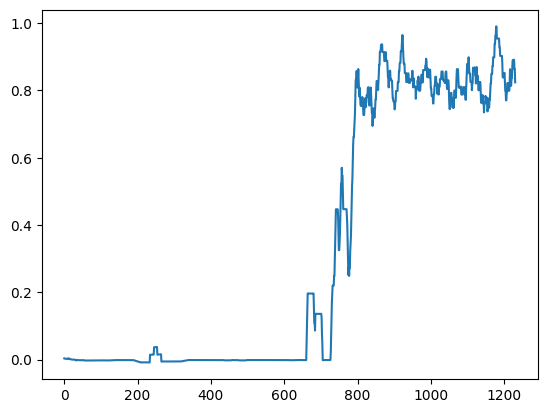

In [43]:
import matplotlib.pyplot as plt
per_episode_reward = output['reward'].mean(axis=-1).reshape(-1, config["HORIZON"]).sum(axis=-1)
plt.plot(moving_average(per_episode_reward, 20))

## Adam LMCDQN

### Adam SLGD Optimizer

In [44]:
# adam slgd optimizer
import optax

class AddNoiseState(NamedTuple):
  """State for adding gradient noise. Contains a count for annealing."""
  count: chex.Array
  rng_key: chex.PRNGKey


def add_slgd_noise(
    learning_rate,
    temperature,
    rng_key: chex.PRNGKey
) -> optax.GradientTransformation:
  """Add gradient noise.

  References:
    [Neelakantan et al, 2014](https://arxiv.org/abs/1511.06807)

  Args:
    eta: Base variance of the gaussian noise added to the gradient.
    gamma: Decay exponent for annealing of the variance.
    rng_key: JAX PRNGKey.

  Returns:
    A `GradientTransformation` object.
  """
  learning_rate_fn = lambda count: learning_rate(count) if callable(learning_rate) else learning_rate
  temp_fn = lambda count: temperature(count) if callable(temperature) else temperature

  def init_fn(params):
    del params
    return AddNoiseState(
        count=jnp.zeros([], jnp.int32), rng_key=rng_key)

  def update_fn(updates, state, params=None):  # pylint: disable=missing-docstring
    del params
    num_vars = len(jax.tree_util.tree_leaves(updates))
    treedef = jax.tree_util.tree_structure(updates)
    count_inc = optax.safe_int32_increment(state.count)
    lr = learning_rate_fn(count_inc)
    temp = temp_fn(count_inc)
    variance = 2 * lr * temp
    standard_deviation = jnp.sqrt(variance)
    all_keys = jax.random.split(state.rng_key, num=num_vars + 1)
    noise = jax.tree_util.tree_map(
        lambda g, k: jax.random.normal(k, shape=g.shape, dtype=g.dtype),
        updates, jax.tree_util.tree_unflatten(treedef, all_keys[1:]))
    updates = jax.tree_util.tree_map(
        lambda g, n: g + standard_deviation.astype(g.dtype) * n,
        updates, noise)
    return updates, AddNoiseState(count=count_inc, rng_key=all_keys[0])

  return optax.GradientTransformation(init_fn, update_fn)


def adam_slgd(learning_rate,
              temperature,
              rng_key: chex.PRNGKey,
              b1: float = 0.9,
              b2: float = 0.999,
              eps: float = 1e-8,
              eps_root: float = 0.,
              weight_decay: float = 1e-4):
  scale_learning_rate = optax.scale_by_schedule(lambda count: -1 * learning_rate) if callable(learning_rate) else optax.scale(-1 * learning_rate)
  return optax.chain(
      optax.scale_by_adam(
          b1=b1, b2=b2, eps=eps, eps_root=eps_root, mu_dtype=None),
      optax.add_decayed_weights(weight_decay, None),
      scale_learning_rate,
      add_slgd_noise(learning_rate, temperature, rng_key)
  )

### LMC DQN

In [45]:


def make_lmc_dqn_train(config):
  def train(rng):
    rng, rng_ = jax.random.split(rng)

    # init q-network
    params = env.default_params
    obs, _ = env.reset(rng_, params)
    q_network = QNetwork(n_actions=env.num_actions,
                         n_hidden=config["Q_NETWORK_N_HIDDEN"],
                         n_features=config["Q_NETWORK_N_FEATURES"])
    rng, rng1, rng2 = jax.random.split(rng, 3)
    # tx = adam_slgd(learning_rate=config["LMC_LR"], temperature=config["LMC_TEMP"], rng_key=rng2, weight_decay=0.)
    # tx = optax.adamw(learning_rate=config["LMC_LR"])
    tx = optax.chain(optax.adam(learning_rate=config["LMC_LR"]),
                     add_slgd_noise(learning_rate=config["LMC_LR"], temperature=config["LMC_TEMP"], rng_key=rng2),
                     optax.clip_by_global_norm(config["MAX_GRAD_NORM"]))
    q_state = Q_TrainState.create(apply_fn=q_network.apply,
                                params=q_network.init(rng1, obs[None, ...]),
                                target_params=q_network.init(rng1, obs[None, ...]),
                                tx = tx)

    rng, rng_ = jax.random.split(rng)
    env_params = jax.vmap(env.init_env, in_axes=(0, None))(jax.random.split(rng_, config["NUM_ENVS"]), params)
    rng, rng_ = jax.random.split(rng)
    obs, env_state = jax.vmap(env.reset, in_axes=(0, 0))(jax.random.split(rng_, config["NUM_ENVS"]), env_params)

    # replay buffer
    rng, rng_ = jax.random.split(rng)
    buffer = fbx.make_item_buffer(max_length=config["LMC_BUFFER_SIZE"],
                                  min_length=config["LMC_BATCH_SIZE"],
                                  sample_batch_size=config["LMC_BATCH_SIZE"])
    buffer_state = buffer.init({"obs": obs,
                         "action": jnp.zeros((config["NUM_ENVS"], ), dtype=jnp.int32),
                         "reward": jnp.zeros((config["NUM_ENVS"], )),
                         "done": jnp.zeros((config["NUM_ENVS"], ), dtype=jnp.bool_),
                         "next_obs": obs})


    def update_q_network(q_state, batch):
      # shapes: (batch_size, num_envs, ...)
      obs, action, next_obs, reward, done = batch["obs"], batch["action"], batch["next_obs"], batch["reward"], batch["done"]
      # create new arrays with the first two shapes multiplied
      # TODO multiple q networks and batch size
      obs = obs.reshape((-1, *obs.shape[2:]))
      action = action.reshape((-1, ))
      next_obs = next_obs.reshape((-1, *next_obs.shape[2:]))
      reward = reward.reshape((-1, ))
      done = done.reshape((-1, ))

      q_next_target = q_network.apply(q_state.target_params, next_obs)
      q_next_target = jnp.max(q_next_target, axis=-1)
      q_value = reward + config["LMC_DISCOUNT_FACTOR"] * q_next_target * (1. - done)

      def td_loss(params):
        q_pred = q_network.apply(params, obs) # (batch_size, n_actions)
        q_pred = q_pred[jnp.arange(q_pred.shape[0]), action.squeeze()]
        return jnp.mean((q_pred - q_value)**2), q_pred

      (loss_value, q_pred), grad = jax.value_and_grad(td_loss, has_aux=True)(q_state.params)
      q_state = q_state.apply_gradients(grads=grad)
      return loss_value, q_pred, q_state

    def _env_step(runner_state, i):
      obs, env_state, q_state, rng, buffer_state = runner_state

      # action from q network
      action = jnp.argmax(q_network.apply(q_state.params, obs), axis=-1)

      rng, rng_ = jax.random.split(rng)
      next_obs, env_state, reward, done, info = jax.vmap(env.step, in_axes=(0, 0, 0, 0))(jax.random.split(rng_, config["NUM_ENVS"]), env_state, action, env_params)

      # add to replay buffer
      buffer_state = buffer.add(buffer_state, {"obs": obs,
                                "action": action,
                                "reward": reward,
                                "done": done,
                                "next_obs": next_obs})

      def _train():
        # sample from replay buffer
          k, rng_ = jax.random.split(rng)
          batch = buffer.sample(buffer_state, rng_)
          # train q network
          l, qp, qs = update_q_network(q_state, batch.experience)
          return k, l, qp, qs

      def _no_train():
        # sample from replay buffer
          k, rng_ = jax.random.split(rng)
          batch = buffer.sample(buffer_state, rng_)
          # train q network
          l, qp, qs = update_q_network(q_state, batch.experience)
          return k, jnp.zeros_like(l), jnp.zeros_like(qp), q_state
      # training
      rng, loss, q_pred, q_state = jax.lax.cond((i % config["LMC_TRAIN_FREQ"] == 0),
                                           _train, _no_train)

      q_state = jax.lax.cond((i % config["LMC_TARGET_NETWORK_FREQ"] == 0),
                             lambda: q_state.replace(target_params=q_state.params),
                             lambda: q_state)

      runner_state = (next_obs, env_state, q_state, rng, buffer_state)
      return runner_state, {"loss": loss, "reward": reward, "done": done}

    runner_state = (obs, env_state, q_state, rng, buffer_state)
    runner_state, output = jax.lax.scan(_env_step, runner_state, jnp.arange(config["LMC_EPOCHS"]))

    return runner_state, output
  return train

In [46]:
cnfg.update("jax_disable_jit", False)
config["LMC_TEMP"] = 1e-2
train_lmc = jax.jit(make_lmc_dqn_train(config))
runner_state, lmc_output = train_lmc(jax.random.PRNGKey(1234))

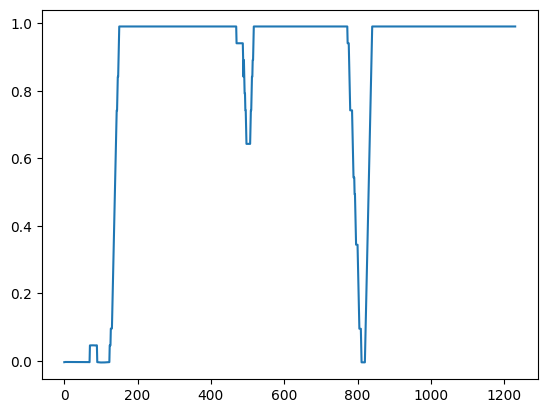

In [47]:
import matplotlib.pyplot as plt
per_episode_reward = lmc_output['reward'].mean(axis=-1).reshape(-1, config["HORIZON"]).sum(axis=-1)
plt.plot(moving_average(per_episode_reward, 20))

## Max-Entropy LMC DQN

### Expert log likelihood function

In [48]:
def make_expert_log_likelihood_fn(config):
    def expert_log_likelihood_fn(
        q_state: Q_TrainState,
        unobserved_context: chex.Array,
        trajectory: Trajectory
    ):
        obs = trajectory.obs  # n_trajectory x n_horizon x obs_dim
        actions = trajectory.action  # n_trajectory x n_horizon x action_dim

        # n_trajectory x n_horizon x num_actions
        q_values = jax.vmap(lambda obs, unobs: q_state.apply_fn(q_state.params, obs, unobs), in_axes=(0, None))(obs, unobserved_context)

        # this is only for discrete actions
        i, j = jnp.meshgrid(jnp.arange(q_values.shape[0]), jnp.arange(q_values.shape[1]), indexing='ij')
        taken_q_values = q_values[i, j, actions.squeeze()]

        denominator = jax.scipy.special.logsumexp(
            config["EXPERT_BETA"] * q_values, axis=2
        )  # n_trajectory x n_horizon

        numerator = config["EXPERT_BETA"] * taken_q_values  # n_trajectory x n_horizon
        # TODO in the case of large horizon, this might get large
        return (numerator - denominator).sum(axis=1) # n_trajectory

    return expert_log_likelihood_fn


### Max entropy LMC DQN

In [49]:
class QNetwork(nn.Module):
  n_actions: int
  n_hidden: int
  n_features: int

  @nn.compact
  def __call__(self, x: jnp.ndarray, unobs_context: jnp.ndarray):
    assert unobs_context.shape[-1] == self.n_features
    if len(unobs_context.shape) == 2:
      assert unobs_context.shape[0] == x.shape[0]
    elif len(unobs_context.shape) > 2:
      raise NotImplementedError

    x = x.reshape((x.shape[0], -1))
    x = nn.Dense(self.n_hidden)(x)
    x = nn.relu(x)
    x = nn.Dense(self.n_features)(x)
    x = jnp.multiply(x, unobs_context) # TODO maybe add some nonlinearity here
    x = nn.Dense(self.n_actions)(x)
    return x


def make_max_ent_lmc_dqn_train(config):
  def train(rng, expert_trajectories):
    rng, rng_ = jax.random.split(rng)

    # init q-network and unobserved contexts
    params = env.default_params
    obs, _ = env.reset(rng_, params)
    q_network = QNetwork(n_actions=env.num_actions,
                         n_hidden=config["Q_NETWORK_N_HIDDEN"],
                         n_features=config["Q_NETWORK_N_FEATURES"])

    rng, rng_ = jax.random.split(rng)
    tx = optax.chain(optax.adam(learning_rate=config["LMC_LR"]),
                     add_slgd_noise(learning_rate=config["LMC_LR"],
                                    temperature=config["LMC_TEMP"],
                                    rng_key=rng_))

    rng, rng_ = jax.random.split(rng)
    unobs_cntxt_tx = optax.chain(optax.adam(learning_rate=config["MAX_ENT_LMC_LR"]),
                                    add_slgd_noise(learning_rate=config["MAX_ENT_LMC_LR"],
                                                   temperature=config["MAX_ENT_LMC_TEMP"],
                                                   rng_key=rng_))

    if config["MAX_GRAD_NORM"] is not None:
      unobs_cntxt_tx = optax.chain(unobs_cntxt_tx, optax.clip_by_global_norm(config["MAX_GRAD_NORM"]))
      tx = optax.chain(tx, optax.clip_by_global_norm(config["MAX_GRAD_NORM"]))

    rng, rng_ = jax.random.split(rng)
    q_state = Q_TrainState.create(apply_fn=q_network.apply,
                                params=q_network.init(rng_, obs[None, ...], jnp.ones((config["Q_NETWORK_N_FEATURES"], ))),
                                target_params=q_network.init(rng_, obs[None, ...], jnp.ones((config["Q_NETWORK_N_FEATURES"], ))),
                                tx = tx)

    rng, rng_ = jax.random.split(rng)
    unobs_state = TrainState.create(apply_fn=None,
                                    params=jax.random.normal(rng_, shape=(config["NUM_ENVS"], config["Q_NETWORK_N_FEATURES"])),
                                    tx=unobs_cntxt_tx)

    # max entropy prior
    expert_log_likelihood_fn = make_expert_log_likelihood_fn(config)
    rng, rng_ = jax.random.split(rng)
    sampled_unobserved_contexts = jax.random.normal(rng_, (config["MAX_ENT_PRIOR_MC_SAMPLES"], config["Q_NETWORK_N_FEATURES"]))

    rng, rng_ = jax.random.split(rng)

    emp_entropy = 0.  # TODO
    n_trajectory = expert_trajectories.obs.shape[0]

    def max_ent_log_prior_fn(max_ent_params, unobs_context, q_state):
      log_likelihoods = expert_log_likelihood_fn(
          q_state, unobs_context, expert_trajectories
      )
      return jnp.exp(log_likelihoods) @ jnp.exp(max_ent_params["log_alphas"])

    max_ent_state = TrainState.create(apply_fn=max_ent_log_prior_fn,
                                      params={"log_alphas": jax.random.normal(rng_, (n_trajectory, 1))},
                                      tx=optax.adam(config["MAX_ENT_LR"]))

    def make_max_ent_update_step(traj_log_likelihoods):
      def max_ent_update_step(state, _):
        def _loss_fn(params):
            alphas = jnp.exp(params["log_alphas"])
            m_alpha = jnp.exp(traj_log_likelihoods) @ alphas
            loss = (
                -jax.scipy.special.logsumexp(
                    m_alpha, axis=0, b=1.0 / m_alpha.shape[0]
                )
                + config["MAX_ENT_LAMBDA"] * jnp.log(alphas / config["MAX_ENT_LAMBDA"]).sum()
                + n_trajectory
                * config["MAX_ENT_LAMBDA"]
                * (1 - config["MAX_ENT_EPSILON"] - jnp.log(n_trajectory) + emp_entropy)
            )  # TODO fix
            return -loss.mean()

        loss, grad = jax.value_and_grad(_loss_fn)(state.params)
        new_state = state.apply_gradients(grads=grad)

        return new_state, {"loss": loss}
      return max_ent_update_step


    # set up the environment
    rng, rng_ = jax.random.split(rng)
    env_params = jax.vmap(env.init_env, in_axes=(0, None))(jax.random.split(rng_, config["NUM_ENVS"]), params)
    rng, rng_ = jax.random.split(rng)
    obs, env_state = jax.vmap(env.reset, in_axes=(0, 0))(jax.random.split(rng_, config["NUM_ENVS"]), env_params)

    # replay buffer
    rng, rng_ = jax.random.split(rng)
    buffer = fbx.make_item_buffer(max_length=config["LMC_BUFFER_SIZE"],
                                  min_length=config["LMC_BATCH_SIZE"],
                                  sample_batch_size=config["LMC_BATCH_SIZE"])

    buffer_state = buffer.init({"obs": obs,
                         "action": jnp.zeros((config["NUM_ENVS"], ), dtype=jnp.int32),
                         "reward": jnp.zeros((config["NUM_ENVS"], )),
                         "done": jnp.zeros((config["NUM_ENVS"], ), dtype=jnp.bool_),
                         "next_obs": obs})


    def update_q_network_unobs_context(q_state, unobs_state, max_ent_state, batch):
      # shapes for the inputs: (batch_size, num_envs, ...)
      obs, action, next_obs, reward, done = batch["obs"], batch["action"], batch["next_obs"], batch["reward"], batch["done"]
      # shape, (batch_size, num_envs, action_dim)
      q_next_target = jax.vmap(q_network.apply, in_axes=(None, 1, 0), out_axes=(1))(q_state.target_params, next_obs, unobs_state.params)
      q_next_target = jnp.max(q_next_target, axis=-1) # (batch_size, num_envs)
      q_value = reward + config["LMC_DISCOUNT_FACTOR"] * q_next_target * (1. - done)
      i, j = jnp.meshgrid(jnp.arange(q_value.shape[0]), jnp.arange(q_value.shape[1]), indexing='ij')

      def td_max_ent_loss(params, unobs_params):
        q_pred = jax.vmap(q_network.apply, in_axes=(None, 1, 0), out_axes=(1))(params, obs, unobs_params) # (batch_size, num_envs, n_actions)
        # pick the q value for the action taken
        q_pred = q_pred[i, j, action.squeeze()]  # (batch_size, num_envs)
        max_ent_log_prior = jax.vmap(max_ent_state.apply_fn, in_axes=(None, 0, None))(max_ent_state.params, unobs_params, q_state)  # (num_envs,)
        loss = (jnp.sum((q_pred - q_value)**2, axis=0) - max_ent_log_prior).mean()
        return loss, q_pred

      (loss_value, q_pred), (grad, unobs_grad) = jax.value_and_grad(td_max_ent_loss, argnums=(0, 1), has_aux=True)(q_state.params, unobs_state.params)
      q_state = q_state.apply_gradients(grads=grad)
      # apply unobserved context gradient
      unobs_state = unobs_state.apply_gradients(grads=unobs_grad)
      return loss_value, q_pred, q_state, unobs_state

    def _env_step(runner_state, i):
      obs, env_state, q_state, unobs_state, max_ent_state, rng, buffer_state = runner_state

      # train max entropy prior
      log_likelihood_fn = lambda unobserved_context: expert_log_likelihood_fn(
        q_state, unobserved_context, expert_trajectories
      )
      # prior_n_samples x n_trajectory
      traj_log_likelihoods = jax.lax.map(
          log_likelihood_fn, sampled_unobserved_contexts
      )

      max_ent_update_step = make_max_ent_update_step(traj_log_likelihoods)
      max_ent_state, metrics = jax.lax.scan(
          max_ent_update_step,
          init=max_ent_state,
          xs=None,
          length=config["MAX_ENT_EPOCHS"],
      )

      # action from q network
      q_values = q_network.apply(q_state.params, obs, unobs_state.params)
      action = jnp.argmax(q_values, axis=-1)


      rng, rng_ = jax.random.split(rng)
      next_obs, env_state, reward, done, info = jax.vmap(env.step, in_axes=(0, 0, 0, 0))(jax.random.split(rng_, config["NUM_ENVS"]), env_state, action, env_params)

      # add to replay buffer
      buffer_state = buffer.add(buffer_state, {"obs": obs,
                                "action": action,
                                "reward": reward,
                                "done": done,
                                "next_obs": next_obs})

      def _train():
        # sample from replay buffer
        k, rng_ = jax.random.split(rng)
        batch = buffer.sample(buffer_state, rng_).experience
        # train q network
        # Update multiple times using jax.lax.scan
        def _update_q_network_unobs_context(run_state, _):
          q_state, unobs_state = run_state
          l, qp, qs, us = update_q_network_unobs_context(q_state, unobs_state, max_ent_state, batch)
          run_state = (qs, us)
          return run_state, (l, qp)

        run_state = (q_state, unobs_state)
        run_state, (loss, q_pred) = jax.lax.scan(_update_q_network_unobs_context, run_state, jnp.arange(config["MAX_ENT_LMC_NUM_UPDATES"]))
        return k, loss.mean(), q_pred.mean(axis=0), run_state[0], run_state[1]

      def _no_train():
        # sample from replay buffer
        return rng, 0., jnp.zeros((config["LMC_BATCH_SIZE"], config["NUM_ENVS"])), q_state, unobs_state

      # training
      rng, loss, q_pred, q_state, unobs_state = jax.lax.cond((i % config["LMC_TRAIN_FREQ"] == 0), _train, _no_train)

      q_state = jax.lax.cond((i % config["LMC_TARGET_NETWORK_FREQ"] == 0),
                             lambda: q_state.replace(target_params=q_state.params),
                             lambda: q_state)

      runner_state = (next_obs, env_state, q_state, unobs_state, max_ent_state, rng, buffer_state)
      return runner_state, {"loss": loss, "reward": reward, "done": done}

    runner_state = (obs, env_state, q_state, unobs_state, max_ent_state, rng, buffer_state)
    runner_state, output = jax.lax.scan(_env_step, runner_state, jnp.arange(config["MAX_ENT_LMC_EPOCHS"]))

    return runner_state, output
  return train

In [50]:
cnfg.update("jax_disable_jit", False)
train_max_ent_lmc = jax.jit(make_max_ent_lmc_dqn_train(config))
runner_state, ent_lmc_output = train_max_ent_lmc(jax.random.PRNGKey(1234), expert_trajectories)

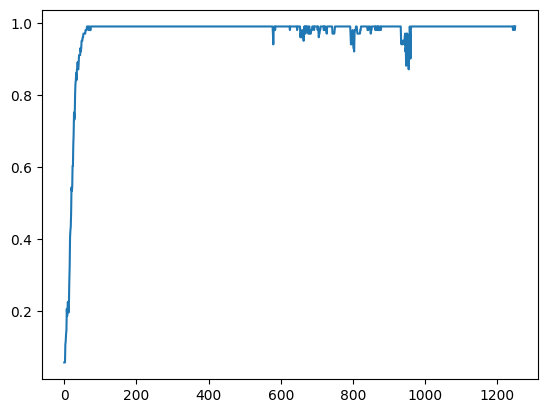

In [54]:
import matplotlib.pyplot as plt
per_episode_reward = ent_lmc_output['reward'].mean(axis=-1).reshape(-1, config["HORIZON"]).sum(axis=-1)
plt.plot(moving_average(per_episode_reward, 1))

## All Final Results

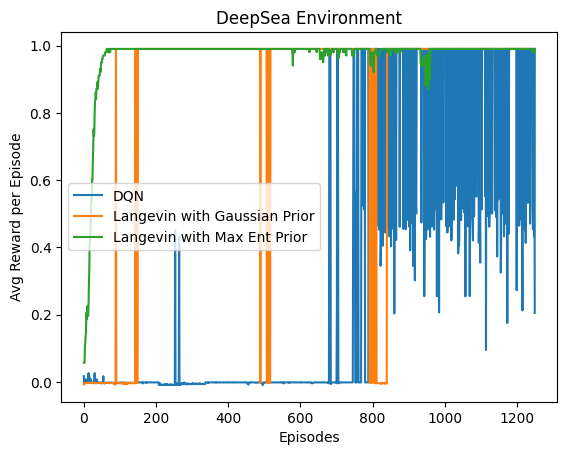

In [55]:
plt.plot(moving_average(output['reward'].mean(axis=-1).reshape(-1, config["HORIZON"]).sum(axis=-1), 1), label="DQN")
plt.plot(moving_average(lmc_output['reward'].mean(axis=-1).reshape(-1, config["HORIZON"]).sum(axis=-1), 1), label="Langevin with Gaussian Prior")
plt.plot(moving_average(ent_lmc_output['reward'].mean(axis=-1).reshape(-1, config["HORIZON"]).sum(axis=-1), 1), label="Langevin with Max Ent Prior")

plt.xlabel("Episodes")
plt.ylabel("Avg Reward per Episode")
plt.title("DeepSea Environment")
plt.legend()

plt.show()